In [2]:
import pandas as pd
import numpy as np
import datetime
import string
import names
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ADJECTIVES = [
    'cool','smart','beautiful','funky','dorky', 'babyish', 'back', 'bad', 'baggy', 'bare', 'barren', 'dorky', 'bad'
    'calculating', 'calm', 'candid', 'canine', 'capital', 'carefree', 'hairy', 'half', 'handmade', 'handsome', 'handy',
    'crazy', 'deliberate'
]

PEOPLE = [
    names.get_first_name().lower() for i in range(1000)
]

PRODUCTS = [
    'airplane','banana','train','bow','map','skull'
]

In [4]:
def name_generator(adj,sub,number_names=10):
    if number_names >= len(adj)*len(sub):
        raise ValueError("can't generate this many names")
    res = set()
    while len(res) < number_names+1:
        new_name = f'{np.random.choice(adj)}_{np.random.choice(sub)}'
        res = res | set([new_name])
    return list(res)

In [5]:
def generate_order_id(size=16, chars=list(string.ascii_uppercase + string.digits)):
    return ''.join(np.random.choice(chars) for _ in range(size))

In [6]:
def generate_dummy_data(
    dummy_products,
    dummy_customers,
    dummy_customer_types = ['company','private','government'],
    first_date=datetime.datetime(2014,1,1),
    last_date=datetime.datetime(2018,1,1),
    data_points=1000):
    
    customer_type = {customer:np.random.choice(['company','private','government']) for customer in dummy_customers}
    product_prices = {product:np.random.randint(100,10000) for product in dummy_products}

    df = pd.DataFrame({
        'order_id' : [generate_order_id() for i in range(data_points)],
        'order_date' : [np.random.choice(pd.date_range(first_date,last_date)) for i in range(data_points)],
        'customer' : [np.random.choice(customers) for i in range(data_points)],
        'product' : [np.random.choice(products) for i in range(data_points)],
        'order_size': [np.random.randint(1,5) for i in range(data_points)]
    })
    df['customer_type'] = df['customer'].map(customer_type)
    df['product_price'] = df['product'].map(product_prices)
    df['basket_size'] = df['order_size']*df['product_price']
    
    return df

In [7]:
customers = name_generator(ADJECTIVES,PEOPLE,2000)
products = name_generator(ADJECTIVES, PRODUCTS, 10)

In [8]:
products[:5]

['bad_bow', 'half_bow', 'capital_map', 'babyish_skull', 'handsome_map']

In [9]:
df = generate_dummy_data(products,customers)

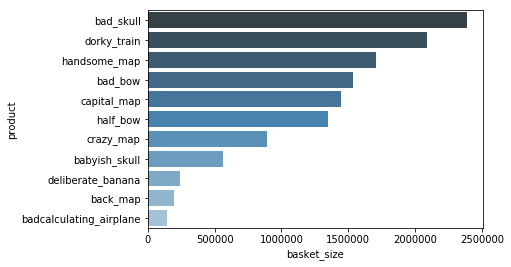

In [19]:
# Total order value by products
sns.barplot(
    x='basket_size', 
    y='product', 
    data=pd.DataFrame(df.groupby('product')['basket_size'].sum().sort_values(ascending=False)).reset_index(), 
    palette="Blues_d"
)

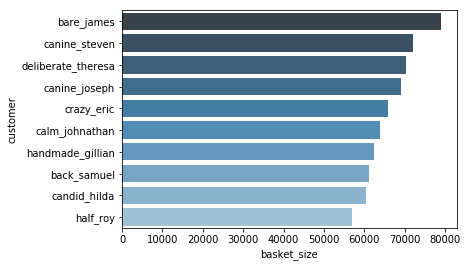

In [20]:
# Total order value by customers
sns.barplot(
    x='basket_size', 
    y='customer', 
    data=pd.DataFrame(df.groupby('customer')['basket_size'].sum().sort_values(ascending=False)).reset_index().head(10), 
    palette="Blues_d"
)

# Data enrichtment (generate first oder dates and add)

In [21]:
customer_data = pd.DataFrame(df.groupby('customer')['order_date'].min())
customer_data.columns = ['customer_first_order']
customer_data.head(2)

,customer_first_order
customer,
babyish_andrea,2014-03-21
babyish_antonia,2016-02-15


In [22]:
df.loc[df.customer.isin(list(customer_data.index[0:2]))].sort_values(by=['customer','order_date'])

,order_id,order_date,customer,product,order_size,customer_type,product_price,basket_size
907,6VJPTSI9N5HFUNLI,2014-03-21,babyish_andrea,back_map,2,government,907,1814
657,IA6VLXYDKVSJU8WZ,2014-11-15,babyish_andrea,dorky_train,2,government,8988,17976
728,VR1K76YFPJDD8BCP,2016-02-15,babyish_antonia,badcalculating_airplane,1,company,606,606


In [23]:
df = pd.merge(df,customer_data.reset_index(),on='customer')
df.head(2)

,order_id,order_date,customer,product,order_size,customer_type,product_price,basket_size,customer_first_order
0,ZFLIK94XYE9HKI18,2015-04-01,beautiful_rosia,capital_map,4,government,5227,20908,2015-04-01
1,735GTB55623C7SRJ,2017-05-02,hairy_carrie,badcalculating_airplane,2,private,606,1212,2017-05-02


In [24]:
#determine if a order is a repeat order or first order
df['type_of_order'] = np.where(df['order_date'] != df['customer_first_order'], 'repeat', 'first')

In [25]:
def _fortmat_quarter(x):
    quarter = (x.month-1)//3 + 1    
    return str(x.year)+'-Q'+str(quarter)

def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'order_id':pd.Series.nunique,
        'order_size':sum,
        'basket_size':sum
    })
    cohorts.columns = ['number_of_orders','number_of_items_bought','total_order_value']
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

def _generate_repeat_percentages(dataset,metric):
    repeat_perc = dataset.groupby(['cohort', 'type_of_order']).agg({
        'order_id':pd.Series.nunique,
        'order_size':sum,
        'basket_size':sum
    }).unstack()

    repeat_perc = repeat_perc.stack().T.stack(level=0).fillna(0)
    repeat_perc['percentage repeat'] = repeat_perc['repeat']/repeat_perc.sum(axis=1)
    repeat_perc = repeat_perc.unstack(level=0).iloc[:,-3:]
    
    repeat_perc.columns = ['Orders Repeat %', 'Items Bought Repeat %', 'Order Value Repeat %']

    if metric == 'number_of_orders':
        selection = 'Orders Repeat %'
    if metric == 'number_of_items_bought':
        selection = 'Items Bought Repeat %'
    if metric == 'total_order_value':
        selection = 'Order Value Repeat %'
    if not selection:
        raise NotImplementedError('No repeat figures for specified metric')

    repeat_perc = repeat_perc[selection].reset_index()
    
    return repeat_perc, selection

def generate_cohort_analysis(df, metric, record_type='all', period_agg='quarterly', fig=True, size=10, save_fig=True):
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """

    dataset = df.copy()
    if record_type != 'all':
        dataset = df[df.customer_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='quarterly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: _fortmat_quarter(x))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: _fortmat_quarter(x))
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['order_date'].apply(lambda x: x.strftime('%Y-%m'))
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
        
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'customer': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Accounts']

    # generate repeat data
    repeat_perc, selection = _generate_repeat_percentages(dataset,metric)

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14, 1)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Accounts", y='cohort', data=new_accs, palette="Blues", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap="Blues",
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=False,
                          yticklabels=False,
                          ax=ax2)

    title = 'Retention Matrix for "{}" - for Account Type "{}"'.format(metric, record_type)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('order_period')

    # plot repeat table
    Repeats = sns.barplot(x=selection, y='cohort', data=repeat_perc, palette="Blues", ax=ax3)
    # removes y-axis label
    Repeats.yaxis.get_label().set_visible(False)
    # removes y-axis tickl labels
    Repeats.set(yticklabels=[])
    # removes y-axis ticks themselves
    Repeats.set(yticks=[])
    vals = Repeats.get_xticks()
    Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+record_type+'.png', bbox_inches='tight', dpi=600)



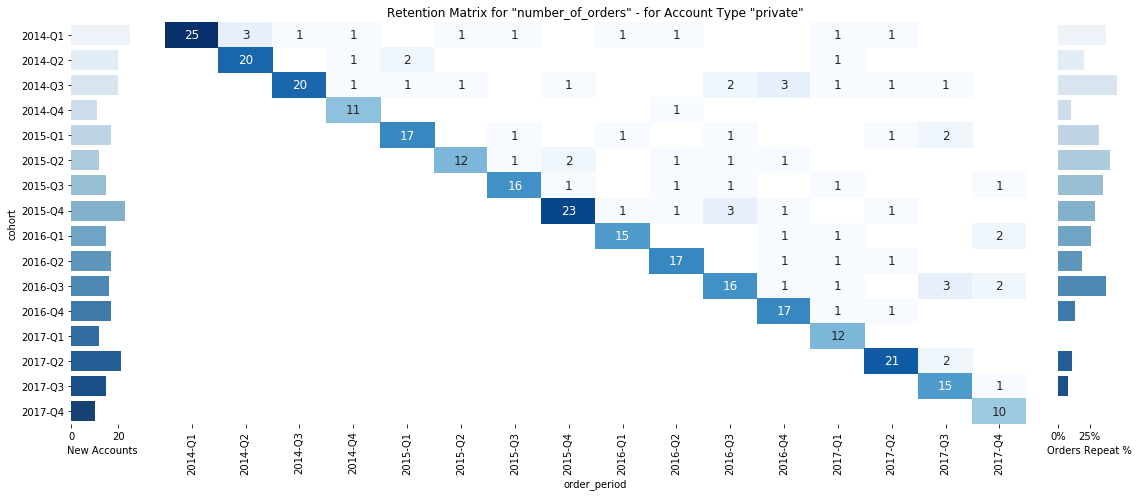

In [26]:
generate_cohort_analysis(df,'number_of_orders',record_type='private',period_agg='quarterly',fig=True, size=12)